In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import gensim


from gensim.models import Word2Vec
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold #Import KFold


from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, SimpleRNN
from tensorflow.keras.utils import to_categorical

# Load the dataset from a CSV file
df = pd.read_csv('D:\kuliah\THE ONLY TA THINGS\DATA\data clean\cleaned_data_5000.csv')
df.head()

,content,score,at,label,cleansing,case_folding,no_unwanted,tokenize,normalization,stopwords,stemming,clean
0,Tanpa keterangan,4,2023-04-07 18:17:53,1,Tanpa keterangan,tanpa keterangan,tanpa keterangan,"['tanpa', 'keterangan']","['tanpa', 'keterangan']",['keterangan'],['terang'],terang
1,Sangat menghibur,5,2023-04-09 22:23:31,1,Sangat menghibur,sangat menghibur,sangat menghibur,"['sangat', 'menghibur']","['sangat', 'menghibur']",['menghibur'],['hibur'],hibur
2,Tidak dapat di instal,1,2023-04-12 21:45:11,-1,Tidak dapat di instal,tidak dapat di instal,tidak dapat di instal,"['tidak', 'dapat', 'di', 'instal']","['tidak', 'dapat', 'di', 'install']",['install'],['install'],install
3,Bagus banget siapapun yg buat ini bagus bgt🤩🤩🤩🤩🤩,5,2023-04-13 16:11:48,1,Bagus banget siapapun yg buat ini bagus bgt,bagus banget siapapun yg buat ini bagus bgt,bagus banget siapapun yg buat ini bagus bgt,"['bagus', 'banget', 'siapapun', 'yg', 'buat', ...","['bagus', 'banget', 'siapapun', 'yang', 'buat'...","['bagus', 'banget', 'bagus', 'banget']","['bagus', 'banget', 'bagus', 'banget']",bagus banget bagus banget
4,Aplikasinya sangat bagus,5,2023-04-08 21:57:58,1,Aplikasinya sangat bagus,aplikasinya sangat bagus,aplikasinya sangat bagus,"['aplikasinya', 'sangat', 'bagus']","['aplikasinya', 'sangat', 'bagus']","['aplikasinya', 'bagus']","['aplikasi', 'bagus']",aplikasi bagus


_`Define Hyperparameter and constatn variables`_

In [2]:
# constants
W2V_MAX_FEATURES = 1000
EPOCH_VAL = 10
NUM_CLASSES = 3
BATCH_SIZE = 32

_`load pre trained model wikipedia bahasa indonesia`_

In [3]:
path = 'D:\kuliah\THE ONLY TA THINGS\MODEL\idwiki_word2vec_300\idwiki_word2vec_300.model'
model_w2v_wiki = gensim.models.word2vec.Word2Vec.load(path)

In [4]:
print(model_w2v_wiki.wv.most_similar('hibur'))

[('tariknya', 0.5085445642471313), ('pakamban', 0.5063350796699524), ('jelma', 0.5030689239501953), ('ungkit', 0.4928063750267029), ('tahannya', 0.48755669593811035), ('tampungnya', 0.4805085062980652), ('kandih', 0.4764712452888489), ('tampung', 0.4750276207923889), ('hantar', 0.47477853298187256), ('mamben', 0.4704032242298126)]


In [5]:
# Split the data into features and labels
# df['tweet_clean'] = df['tweet_clean'].astype(str)
reviews = df['clean'].astype(str).values

raw_label = df['label']
# labels = pd.get_dummies(raw_label).astype(int).values
labels = to_categorical(raw_label, num_classes=3)

In [6]:
print(reviews)

['terang' 'hibur' 'install' ... 'nan' 'oke' 'seru']


# contoh 1

_`Split the data into training and testing sets`_

In [7]:
review_train, review_test, label_train, label_test = train_test_split(reviews, labels, test_size=0.3, random_state=42)

In [8]:
review_train.shape

(3500,)

In [9]:
# Convert text to sequences of integers
tokenizer = Tokenizer(num_words=W2V_MAX_FEATURES)

#tokenize the train data
tokenizer.fit_on_texts(review_train)
word_index = tokenizer.word_index

# Convert the text to sequences of word indices
train_sequences = tokenizer.texts_to_sequences(review_train)
max_sequence_length = max([len(seq) for seq in train_sequences])
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
train_padded_sequences = np.expand_dims(train_padded_sequences, axis=-1)

#tokenize the test data
tokenizer.fit_on_texts(review_test)
test_word_index = tokenizer.word_index

test_sequences = tokenizer.texts_to_sequences(review_test)
# test_max_sequence_length = max([len(seq) for seq in test_sequences])
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')
test_padded_sequences = np.expand_dims(test_padded_sequences, axis=-1)

In [10]:
train_padded_sequences

array([[[  1],
        [  0],
        [  0],
        ...,
        [  0],
        [  0],
        [  0]],

       [[  6],
        [174],
        [175],
        ...,
        [  0],
        [  0],
        [  0]],

       [[973],
        [  9],
        [  0],
        ...,
        [  0],
        [  0],
        [  0]],

       ...,

       [[  1],
        [ 58],
        [ 15],
        ...,
        [  0],
        [  0],
        [  0]],

       [[ 10],
        [  0],
        [  0],
        ...,
        [  0],
        [  0],
        [  0]],

       [[  1],
        [  0],
        [  0],
        ...,
        [  0],
        [  0],
        [  0]]])

In [11]:
# print("x_train: ", train_padded_sequences.shape)
# print("x_test: ", test_padded_sequences.shape)
# print("y_train: ", label_train.shape)
# print("y_test: ", label_test.shape)
# print("max_length: ", max_sequence_length)
# print("max_length_test: ", test_max_sequence_length)

In [12]:
# Create the embedding matrix
embedding_dim = model_w2v_wiki.vector_size
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in model_w2v_wiki:
        embedding_matrix[i] = model_w2v_wiki[word]

C:\Users\Madluke\AppData\Local\Temp\ipykernel_9624\3903320852.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in model_w2v_wiki:
C:\Users\Madluke\AppData\Local\Temp\ipykernel_9624\3903320852.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = model_w2v_wiki[word]


In [13]:
def rnn_model():
    model = Sequential()
    # # add bidirectional LSTM layer
    # model.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(max_length,)))
    model.add(SimpleRNN(units=64, input_shape=(max_sequence_length, 1)))
    # add dropout layer to reduce overfitting
    model.add(Dropout(0.2))
    # add dense layer with softmax activation for multi-class classification
    model.add(Dense(units=3, activation='softmax'))
    # compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
# Train the model
model = rnn_model()
model_fit_result = model.fit(train_padded_sequences, label_train, batch_size=BATCH_SIZE, epochs=EPOCH_VAL, validation_data=(test_padded_sequences, label_test))

Epoch 1/10
110/110 [==============================] - 2s 9ms/step - loss: 0.6302 - accuracy: 0.7751 - val_loss: 0.5778 - val_accuracy: 0.7960
Epoch 2/10
110/110 [==============================] - 1s 6ms/step - loss: 0.5867 - accuracy: 0.8003 - val_loss: 0.5651 - val_accuracy: 0.8013
Epoch 3/10
110/110 [==============================] - 1s 6ms/step - loss: 0.5809 - accuracy: 0.8040 - val_loss: 0.6037 - val_accuracy: 0.7813
Epoch 4/10
110/110 [==============================] - 1s 6ms/step - loss: 0.5828 - accuracy: 0.8040 - val_loss: 0.5563 - val_accuracy: 0.7987
Epoch 5/10
110/110 [==============================] - 1s 6ms/step - loss: 0.5778 - accuracy: 0.8080 - val_loss: 0.5716 - val_accuracy: 0.8053
Epoch 6/10
110/110 [==============================] - 1s 6ms/step - loss: 0.5808 - accuracy: 0.8074 - val_loss: 0.5552 - val_accuracy: 0.7993
Epoch 7/10
110/110 [==============================] - 1s 6ms/step - loss: 0.5805 - accuracy: 0.8049 - val_loss: 0.5547 - val_accuracy: 0.8040
Epoch 

In [15]:
# Predict the labels for the testing data
label_pred_prob = model.predict(test_padded_sequences)
label_pred = label_pred_prob.argmax(axis=1)-1
label_test_one_dim = np.argmax(label_test, axis=1)-1

47/47 [==============================] - 0s 3ms/step


In [16]:
print("RNN-Word2Vec \n")


# print(accuracy_score(label_test_one_dim, label_pred))
print(confusion_matrix(label_test_one_dim, label_pred))
print(classification_report(label_test_one_dim, label_pred))
print("Precision: ",precision_score(label_test_one_dim, label_pred, average="macro"))
print("Recall: ",recall_score(label_test_one_dim, label_pred, average="macro"))
print("F1: ",f1_score(label_test_one_dim, label_pred,  average="macro"))
print("Accuracy: ",accuracy_score(label_test_one_dim, label_pred))

RNN-Word2Vec 

[[   0   64    2]
 [   2 1193   11]
 [   0  218   10]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        66
           0       0.81      0.99      0.89      1206
           1       0.43      0.04      0.08       228

    accuracy                           0.80      1500
   macro avg       0.41      0.34      0.32      1500
weighted avg       0.72      0.80      0.73      1500

Precision:  0.4145320560058954
Recall:  0.34436007099007887
F1:  0.3232159017789343
Accuracy:  0.802


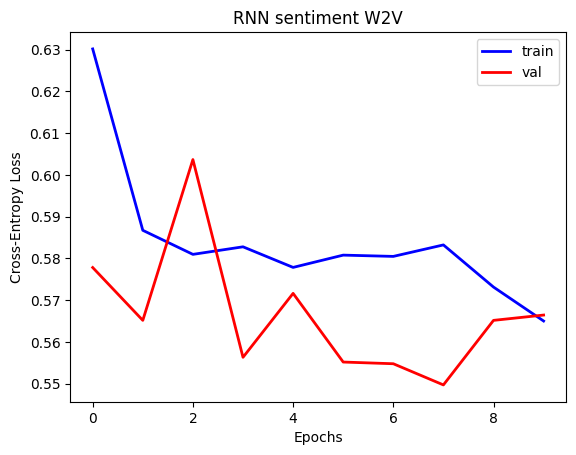

In [17]:
plt.figure()
plt.plot(model_fit_result.history['loss'], lw=2.0, color='b', label='train')
plt.plot(model_fit_result.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('RNN sentiment W2V')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc ='upper right')
plt.show()

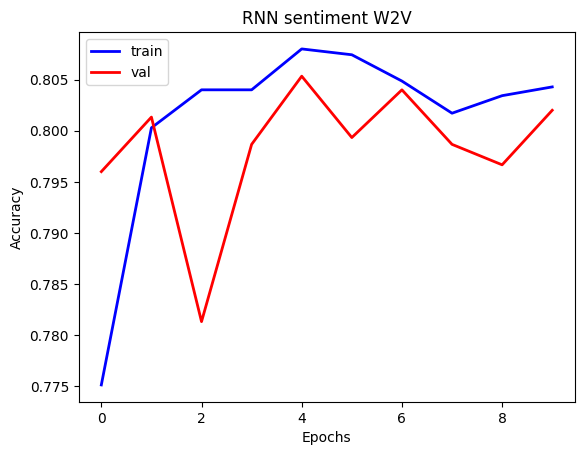

In [18]:
plt.figure()
plt.plot(model_fit_result.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(model_fit_result.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('RNN sentiment W2V')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 4,419
Trainable params: 4,419
Non-trainable params: 0
_________________________________________________________________


## implement with k-fold cross validation

In [20]:
# define the range of K values to test
k_values = range(2, 11)

# create an array to store the maximum accuracy achieved for each K value
max_acc = np.zeros(len(k_values))

# loop over the K values
for i, k in enumerate(k_values):
    # create the KFold object
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # perform cross-validation
    acc_list = []
    for train_idx, test_idx in kf.split(train_padded_sequences, label_train):
        X_train, X_test = train_padded_sequences[train_idx], train_padded_sequences[test_idx]
        y_train, y_test = label_train[train_idx], label_train[test_idx]
        
        # define and fit the model
        model = rnn_model()
        model_fit_kfold = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_VAL, validation_data=(X_test, y_test))
        
        # evaluate the model on the test set and store the accuracy
        acc = model.evaluate(X_test, y_test)[1]
        acc_list.append(acc)
        
    # calculate the maximum accuracy achieved for this K value
    max_acc[i] = np.max(acc_list)
    
# find the K value with the highest maximum accuracy
best_k = k_values[np.argmax(max_acc)]

print(f"Best K value: {best_k}")

Epoch 1/10
55/55 [==============================] - 2s 12ms/step - loss: 0.6194 - accuracy: 0.7817 - val_loss: 0.6003 - val_accuracy: 0.8029
Epoch 2/10
55/55 [==============================] - 0s 7ms/step - loss: 0.5729 - accuracy: 0.8029 - val_loss: 0.6012 - val_accuracy: 0.8023
Epoch 3/10
55/55 [==============================] - 0s 8ms/step - loss: 0.5662 - accuracy: 0.8034 - val_loss: 0.5934 - val_accuracy: 0.7954
Epoch 4/10
55/55 [==============================] - 0s 7ms/step - loss: 0.5703 - accuracy: 0.8017 - val_loss: 0.5986 - val_accuracy: 0.8029
Epoch 5/10
55/55 [==============================] - 0s 7ms/step - loss: 0.5603 - accuracy: 0.8080 - val_loss: 0.5959 - val_accuracy: 0.8011
Epoch 6/10
55/55 [==============================] - 0s 8ms/step - loss: 0.5587 - accuracy: 0.8040 - val_loss: 0.5888 - val_accuracy: 0.8017
Epoch 7/10
55/55 [==============================] - 0s 8ms/step - loss: 0.5505 - accuracy: 0.8097 - val_loss: 0.6137 - val_accuracy: 0.8023
Epoch 8/10
55/55 [=

In [21]:
print("Max accuration Word2Vec-RNN in 10 times k-fold cross validation: \n")

for i, val in enumerate(acc_list, start=2):
    print("Fold {}: {}".format(i, val))

print('\n')
print("max accuracy: ", np.max(acc_list))
print("avg accuracy: ", np.mean(acc_list)*100)

best_k = k_values[np.argmax(max_acc)]
print(f"Best K value: {best_k}")

Max accuration Word2Vec-RNN in 10 times k-fold cross validation: 

Fold 2: 0.8171428442001343
Fold 3: 0.8142856955528259
Fold 4: 0.7799999713897705
Fold 5: 0.800000011920929
Fold 6: 0.7942857146263123
Fold 7: 0.8057143092155457
Fold 8: 0.7857142686843872
Fold 9: 0.8171428442001343
Fold 10: 0.8057143092155457
Fold 11: 0.822857141494751


max accuracy:  0.822857141494751
avg accuracy:  80.42857110500336
Best K value: 10


_`K-fold cross validation with choosen K value (best accuracy)`_

In [22]:
# split data into K folds

Best_K_value = 9

actual_classes = np.empty([0], dtype=int)
predicted_classes = np.empty([0], dtype=int)

kf = KFold(n_splits=Best_K_value, random_state=0, shuffle = True)
for fold, (train_idx, val_idx) in enumerate(kf.split(train_padded_sequences, label_train)):
    
    # Split train data into train and validation sets
    x_train_fold = train_padded_sequences[train_idx]
    y_train_fold = label_train[train_idx]
    x_val_fold = train_padded_sequences[val_idx]
    y_val_fold = label_train[val_idx]

    # build and compile the model
    model = rnn_model()

    # train the model
    result_fit_kfold = model.fit(train_padded_sequences, label_train, batch_size=BATCH_SIZE, epochs=EPOCH_VAL, validation_data=(test_padded_sequences, label_test))

    # evaluate the model on test set
    score = model.evaluate(test_padded_sequences, label_test, batch_size=BATCH_SIZE, verbose=1)
    print("Fold %d: %s: %.2f%%" % (fold+1, model.metrics_names[1], score[1]*100)) 

    # Predict the labels for the testing data
    label_pred_prob = model.predict(test_padded_sequences)
    label_pred = label_pred_prob.argmax(axis=1)-1
    label_test_one_dim = np.argmax(label_test, axis=1)-1

    actual_classes = np.append(actual_classes, label_test_one_dim)
    predicted_classes = np.append(predicted_classes, label_pred)

Epoch 1/10
110/110 [==============================] - 3s 11ms/step - loss: 0.6277 - accuracy: 0.7871 - val_loss: 0.5661 - val_accuracy: 0.8067
Epoch 2/10
110/110 [==============================] - 1s 10ms/step - loss: 0.5912 - accuracy: 0.8026 - val_loss: 0.5560 - val_accuracy: 0.8060
Epoch 3/10
110/110 [==============================] - 2s 16ms/step - loss: 0.5865 - accuracy: 0.8023 - val_loss: 0.5665 - val_accuracy: 0.8013
Epoch 4/10
110/110 [==============================] - 2s 14ms/step - loss: 0.5831 - accuracy: 0.8031 - val_loss: 0.5566 - val_accuracy: 0.8020
Epoch 5/10
110/110 [==============================] - 1s 10ms/step - loss: 0.5797 - accuracy: 0.8023 - val_loss: 0.5504 - val_accuracy: 0.8060
Epoch 6/10
110/110 [==============================] - 1s 11ms/step - loss: 0.5780 - accuracy: 0.8049 - val_loss: 0.5542 - val_accuracy: 0.8067
Epoch 7/10
110/110 [==============================] - 1s 11ms/step - loss: 0.5770 - accuracy: 0.8017 - val_loss: 0.5489 - val_accuracy: 0.8047

In [23]:
print("RNN-Word2Vec w/ kfold (Best_K_value = %2d): \n" %(Best_K_value))
print(accuracy_score(label_test_one_dim, label_pred))
print(confusion_matrix(label_test_one_dim, label_pred))
print(classification_report(label_test_one_dim, label_pred))
print("Precision: ",precision_score(label_test_one_dim, label_pred, average="macro"))
print("Recall: ",recall_score(label_test_one_dim, label_pred, average="macro"))
print("F1: ",f1_score(label_test_one_dim, label_pred,  average="macro"))
print("Accuracy: ",accuracy_score(label_test_one_dim, label_pred))

RNN-Word2Vec w/ kfold (Best_K_value =  9): 

0.808
[[   2   63    1]
 [   0 1206    0]
 [   0  224    4]]
              precision    recall  f1-score   support

          -1       1.00      0.03      0.06        66
           0       0.81      1.00      0.89      1206
           1       0.80      0.02      0.03       228

    accuracy                           0.81      1500
   macro avg       0.87      0.35      0.33      1500
weighted avg       0.82      0.81      0.73      1500

Precision:  0.8692565304755527
Recall:  0.3492822966507177
F1:  0.3289408711596083
Accuracy:  0.808


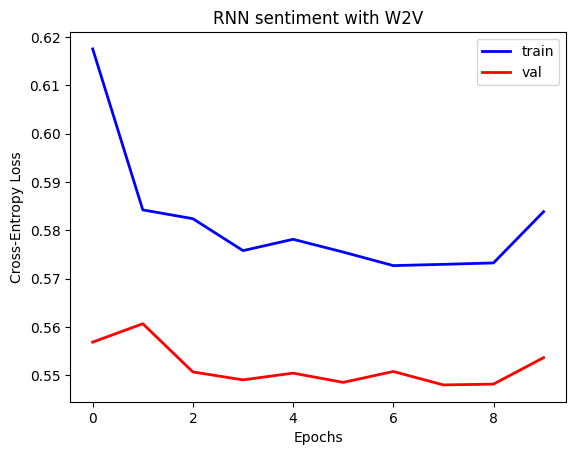

In [24]:
plt.figure()
plt.plot(result_fit_kfold.history['loss'], lw=2.0, color='b', label='train')
plt.plot(result_fit_kfold.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('RNN sentiment with W2V')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc ='upper right')
plt.show()

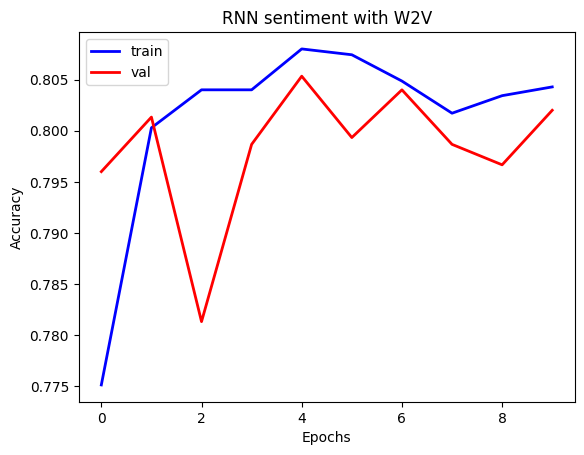

In [25]:
plt.figure()
plt.plot(model_fit_result.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(model_fit_result.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('RNN sentiment with W2V')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# contoh 2

In [26]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=W2V_MAX_FEATURES)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)
max_sequence_length = max([len(seq) for seq in sequences])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 2277 unique tokens.


In [27]:
# Pad the text sequences to the defined length
data = pad_sequences(sequences, maxlen=max_sequence_length)

In [28]:
# Define the model architecture
model = Sequential()
model.add(SimpleRNN(64, input_shape=(max_sequence_length, W2V_MAX_FEATURES)))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

In [29]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
# Train the model
model_fit_result = model.fit(data, labels, epochs=EPOCH_VAL, batch_size=BATCH_SIZE, validation_split=0.2)

Epoch 1/10


ValueError: in user code:

    File "c:\Users\Madluke\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Madluke\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Madluke\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Madluke\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\Madluke\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Madluke\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_64' (type Sequential).
    
    Input 0 of layer "simple_rnn_64" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (32, 32)
    
    Call arguments received by layer 'sequential_64' (type Sequential):
      • inputs=tf.Tensor(shape=(32, 32), dtype=int32)
      • training=True
      • mask=None
